## Set-up 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

/home/evgeniy/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [4]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Initial approach

### Preprocessing

In [5]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [6]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [7]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [8]:
set(events.loc[events['userid'] == "46c1d5ea297bd502e2d7f9dba6056bdd",'device_model'].values)

{'Alcatel_5002R', 'iPhone12,1', nan}

In [9]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3))
)

In [10]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [11]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [12]:
users_info[~(users_info['device3'] == "None")]

,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,
423ffa8cbe761baa995e981904f479db,CA,SM-G981U,SM-G996U1,SM-G998U1,samsung,android,samsung,android,samsung,android


In [13]:
users = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count')
)
users = users.unstack(fill_value=0)
users.columns = [col[1] for col in users.columns]

In [14]:
users = users.join(users_info) 

In [15]:
users

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,samsung,android,NaN,NaN,NaN,NaN
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone11,6",None,None,Apple,ios,NaN,NaN,NaN,NaN
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,FL,SM-G780G,None,None,samsung,android,NaN,NaN,NaN,NaN
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone14,3",None,None,Apple,ios,NaN,NaN,NaN,NaN
003f57fe2631ade57a86f6a2b96bb20c,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone13,4",None,None,Apple,ios,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,SM-N960U,None,None,samsung,android,NaN,NaN,NaN,NaN
ffa1aa12dd53aee84976cb6c525bb17b,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,TX,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN
ffbbc97af52745060a9dff4eb9917f75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PA,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN


### Baseline xgboost

In [16]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [17]:
X = users.drop(columns=["Subscription Premium Cancel"])
y = users["Subscription Premium Cancel"] > 0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [20]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

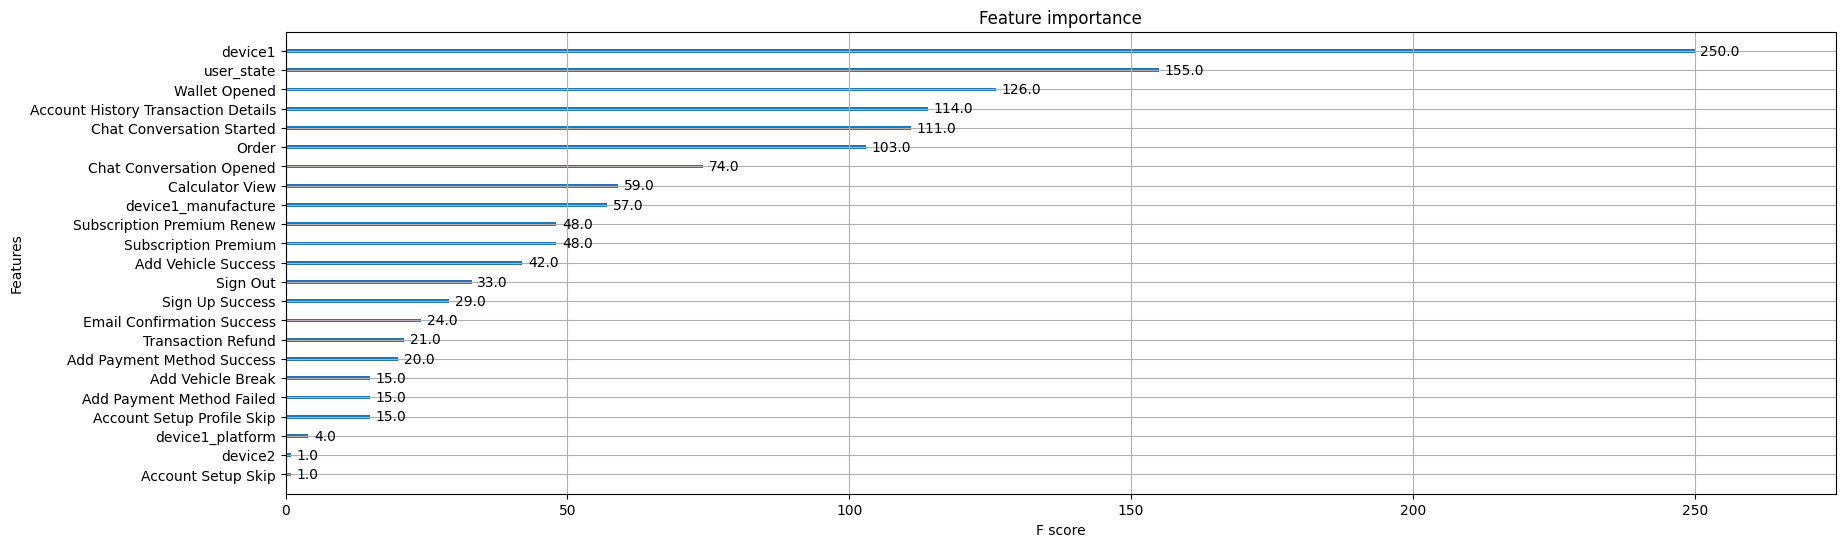

In [21]:
xgb.plot_importance(model)
plt.show()

In [22]:
y_test_pred = model.predict(X_test)

In [23]:
accuracy_score(y_test, y_test_pred)

0.96045197740113

In [24]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.7101449275362319, 0.765625)

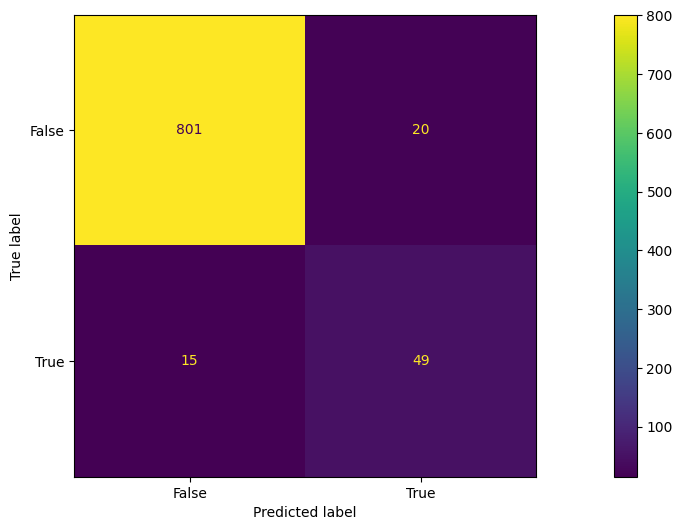

In [25]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

### Devices analysis

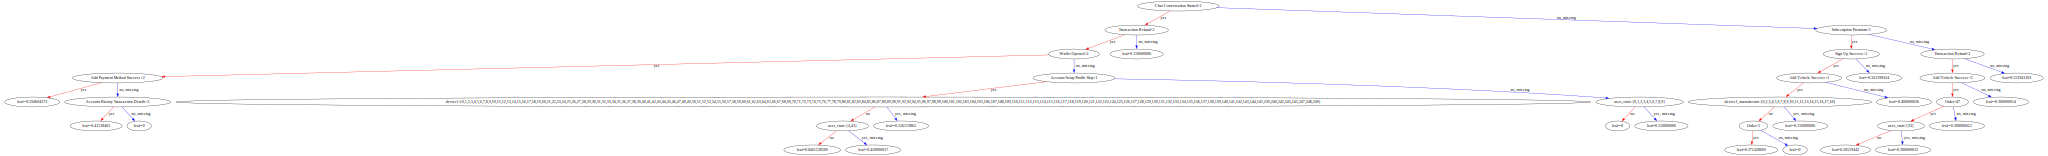

In [26]:
xgb.to_graphviz(model) 

AttributeError: 'XGBClassifier' object has no attribute 'kjii'

### Users and devices

In [ ]:
events[['userid', 'device_model']].groupby('userid').nunique().sort_values('device_model', ascending=False)

In [ ]:
events[['userid', 'user_state']].groupby('userid').nunique().sort_values('user_state', ascending=False)

## Second approach

### Preprocessing

In [45]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [46]:
events['event_created_date'] = pd.to_datetime(events['event_created_date'])
events['ts'] = events['event_created_date'].values.astype(int) // 10 ** 9

In [47]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model,ts
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U,1642352584
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U,1642352867
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1,1642353385
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U,1642353862
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1",1642354491


In [48]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [49]:
set(events.loc[events['userid'] == "46c1d5ea297bd502e2d7f9dba6056bdd",'device_model'].values)

{'Alcatel_5002R', 'iPhone12,1', nan}

In [50]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model', 'event_name', 'ts']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3)),
    most_popular_event=pd.NamedAgg("event_name", lambda x: pd.Series.mode(x)[0] if pd.Series.mode(x)[0] != "Subscription Premium Cancel" else "None"),
    most_popular_device=pd.NamedAgg("device_model", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    num_devices_and_nans=pd.NamedAgg("device_model", lambda x: len(pd.Series.unique(x))),
    # last_event_ts=pd.NamedAgg("ts", pd.Series.max)
)

In [51]:
users_info['last_order_ts'] = events.loc[events['event_name'] == 'Order', ['userid', 'ts']].groupby('userid').max()['ts']

In [52]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [53]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [54]:
users_info[~(users_info['device3'] == "None")]

,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,last_order_ts,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,
423ffa8cbe761baa995e981904f479db,CA,SM-G981U,SM-G996U1,SM-G998U1,Sign Out,SM-G996U1,4,1.648810e+09,samsung,android,samsung,android,samsung,android


In [55]:
users_events = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count'),
)
users_events = users_events.unstack(fill_value=0)
users_events.columns = [col[1] for col in users_events.columns]
# users_events['Events number'] = users_events.sum(axis=1)

In [56]:
users= users_events.join(users_info) 

In [57]:
# users['Orders_fraction'] = users['Order'] / users['Events number']

### Events before cancels

In [58]:
users_cancelled = users_events[users_events['Subscription Premium Cancel'] > 0]

In [59]:
(users_cancelled > 0).sum().sort_values(ascending=False)

Subscription Premium Cancel            251
Add Payment Method Success             228
Subscription Premium                   223
Sign Up Success                        220
Chat Conversation Started              217
Add Vehicle Success                    213
Chat Conversation Opened               189
Wallet Opened                          172
Account History Transaction Details    148
Order                                  102
Calculator View                         79
Transaction Refund                      74
Email Confirmation Success              55
Sign Out                                54
Account Setup Profile Skip              36
Add Vehicle Break                       36
Subscription Premium Renew              35
Add Payment Method Failed               19
Calculator Used                         15
Account Setup Skip                      10
Add Vehicle Failed                       1
Sign Up Error                            1
Reset Password Set                       0
dtype: int6

### xgboost

In [60]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [61]:
users_premium

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,most_popular_event,most_popular_device,num_devices_and_nans,last_order_ts,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,Account History Transaction Details,SM-A716U,2,NaN,samsung,android,NaN,NaN,NaN,NaN
00596aa4edee32815aaf4aad659c484e,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0,0,CA,SM-N976U,None,None,Order,SM-N976U,2,1.646492e+09,samsung,android,NaN,NaN,NaN,NaN
007b54670d72df309afd87befcbb63db,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone13,4",None,None,Chat Conversation Opened,"iPhone13,4",2,NaN,Apple,ios,NaN,NaN,NaN,NaN
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,2,0,0,TX,"iPhone12,1",None,None,Subscription Premium Renew,"iPhone12,1",2,NaN,Apple,ios,NaN,NaN,NaN,NaN
01529f53aaba5b512168d432d5650556,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,IL,moto g play (2021),None,None,Account History Transaction Details,moto g play (2021),2,NaN,motorola,android,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fc9b74bab85fdc6cbdb5b965ca9f760f,1,0,0,0,1,0,0,1,0,0,4,1,0,0,0,0,0,1,1,2,0,0,1,CA,"iPhone12,1",None,None,Chat Conversation Opened,"iPhone12,1",2,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd422ac5f5772dc211a97910ea880db2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,CA,"iPhone14,3",None,None,Add Payment Method Success,"iPhone14,3",2,NaN,Apple,ios,NaN,NaN,NaN,NaN
fd4a11b9abba7352308fabf80c122501,0,0,0,0,1,2,0,5,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,CA,"iPhone12,1","iPhone12,5",None,Add Vehicle Success,"iPhone12,5",3,NaN,Apple,ios,Apple,ios,NaN,NaN


In [62]:
X = users_premium.drop(columns=["Subscription Premium Cancel"])
y = users_premium["Subscription Premium Cancel"] > 0

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [64]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [65]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

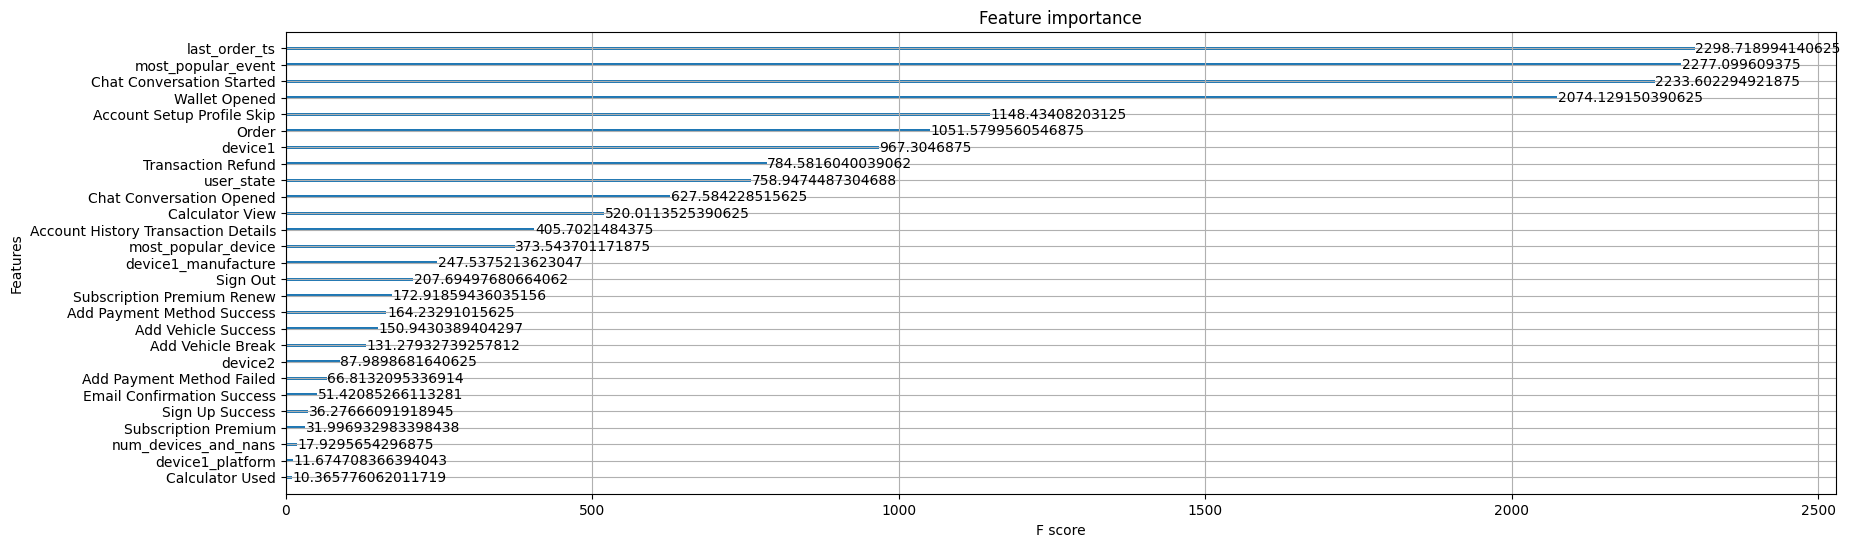

In [77]:
xgb.plot_importance(model, importance_type="total_cover")
plt.show()

In [67]:
model.feature_importances_

array([0.0069274 , 0.02266125, 0.        , 0.01497894, 0.02333031,
       0.00935187, 0.        , 0.03052759, 0.00529473, 0.02805526,
       0.02534296, 0.23769924, 0.02324869, 0.01627923, 0.        ,
       0.008897  , 0.        , 0.01039117, 0.01642225, 0.03899691,
       0.08811817, 0.03433437, 0.01592237, 0.02005204, 0.00571198,
       0.        , 0.06280604, 0.02974618, 0.00634509, 0.01271881,
       0.04629584, 0.15954433, 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

In [68]:
y_test_pred = model.predict(X_test)

In [69]:
accuracy_score(y_test, y_test_pred)

0.8090452261306532

In [70]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.618421052631579, 0.8392857142857143)

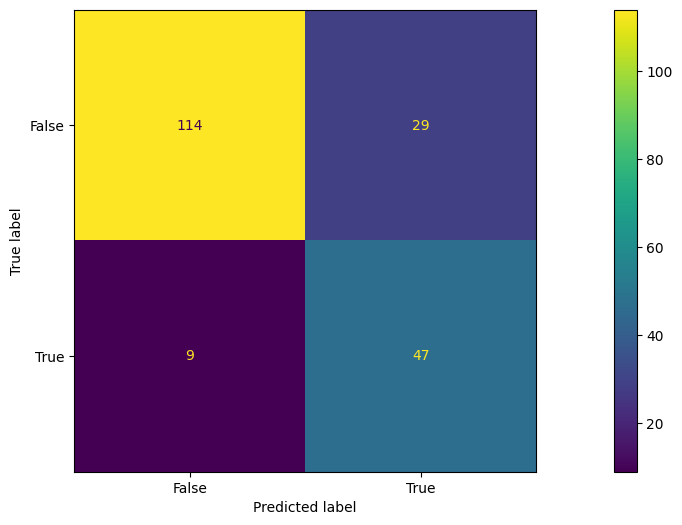

In [71]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)